In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
HLA_associations_path = os.path.abspath("../")
sys.path.append(HLA_associations_path)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import constants, index_tools, data_tools, medical_code_tools
from utilities import *

In [284]:
sns.set_palette("tab10")
plt.rcParams.update({'figure.max_open_warning': 0})

In [272]:
HLA_alleles = data_tools.load_hla_data()

<AxesSubplot:>

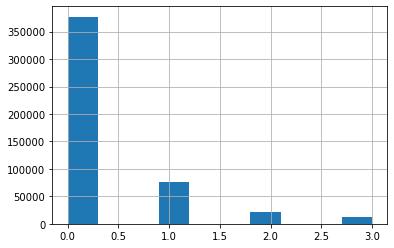

In [273]:
HLA_alleles["zygosity"].hist()

# Grantham Distance

In [274]:
import itertools

os.listdir(grantham_dist_path)
GRANTHAM_DIST_PATH = os.path.abspath("/Users/cole/Documents/_research/rabadan_lab/grantham_distance")

AA_GRANTHAM_TABLE_PATH = os.path.join(GRANTHAM_DIST_PATH, "AAdistMatrix_Grantham.cnv")
HLA_CLASS_I_AA_SEQUENCES_PATH = os.path.join(GRANTHAM_DIST_PATH, 'HLA_ClassI_CWDonly.fas')
HLA_CLASS_I_AA_SEQUENCES_PATH = os.path.join(GRANTHAM_DIST_PATH, "HLA_ClassI_CWDonly_ABSonly.fas")


In [275]:
class HLAAlleleSequenceMapping:
    def __init__(self, HLA_fas_path: str):
        self.load_HLA_allele_AA_mapping(HLA_fas_path)
        
    def parse_fas_section(self, section: str):
        """"""
        assert ">" not in section
        allele, allele_sequence = section.split('\n', maxsplit=1)
        return f"{allele[0]}*{allele[1:3]}:{allele[3:]}", allele_sequence.replace('\n', '')

    def load_HLA_allele_AA_mapping(self, HLA_fas_path: str) -> str:
        """ """
        with open(HLA_fas_path, 'r') as file:
            self.HLA_allele_AA_mapping = dict(self.parse_fas_section(section)
                                              for section in file.read().split(">")[1:])

        return self.HLA_allele_AA_mapping

    def _map(self, alleles: str):
        if isinstance(alleles, str):
            return self.HLA_allele_AA_mapping.get(alleles, None)
        
        return [self._map(allele) for allele in alleles]

HLA_allele_AA_map = HLAAlleleSequenceMapping(HLA_CLASS_I_AA_SEQUENCES_PATH)

In [276]:
class GranthamDistance:
    def __init__(self, grantham_AA_table_path: str):
        self.AA_distance_table = pd.read_csv(grantham_AA_table_path, sep='\t', index_col=0)
        
        self.AA_distance_dict = {}
        for i in self.AA_distance_table.index:
            for j in self.AA_distance_table.columns:
                self.AA_distance_dict[i + j] = self.AA_distance_table.loc[i, j]
    
    def __repr__(self):
        return str(grantham_distance.AA_distance_table)
    
    def AA_pair_distance(self, AA_1: str, AA_2: str) -> int:
        """ """
        return self.AA_distance_dict.get(AA_1.upper() + AA_2.upper(), None)

    def sequence_pair_distance(self, AA_sequence_1: str, AA_sequence_2: str) -> float:
        """"""
        if not (AA_sequence_1 and AA_sequence_2):
            return None

        assert len(AA_sequence_1) == len(AA_sequence_2), f""
        normalize_length = len(AA_sequence_1)
        
        distances = [self.AA_pair_distance(AA_1, AA_2) for AA_1, AA_2 in zip(AA_sequence_1, AA_sequence_2)
                     if AA_1 != AA_2]
        
        if any(dist is None for dist in distances):
            return None
        
        return np.sum(distances) / normalize_length
    
    def sequence_group_distance(self, sequences: list, mean: bool = True) -> float:
        """ Mean of all the pairwise distances"""

        sequence_pairs = itertools.combinations(sequences, 2)
        distances = [self.sequence_pair_distance(*pair) for pair in sequence_pairs]
        if any(dist is None for dist in distances):
            return None
        
        return np.mean(distances)

In [277]:
grantham_distance = GranthamDistance(AA_GRANTHAM_TABLE_PATH)

sequence_1 = HLA_allele_aa_mapping['A*01:01']
sequence_2 = HLA_allele_aa_mapping['A*01:06']
grantham_distance.sequence_pair_distance(sequence_1, sequence_2)

0.9171270718232044

In [278]:
HLA_alleles["grantham_divergence"] = distances

In [280]:
if "grantham_divergence" not in HLA_alleles.columns:
    sequences = HLA_alleles[allele_columns].apply(HLA_allele_AA_map._map, axis=1)
    distances = []
    for sequence in tqdm(sequences, unit=" sequence"):
        distances.append(grantham_distance.sequence_group_distance(sequence))

    HLA_alleles["grantham_divergence"] = distances

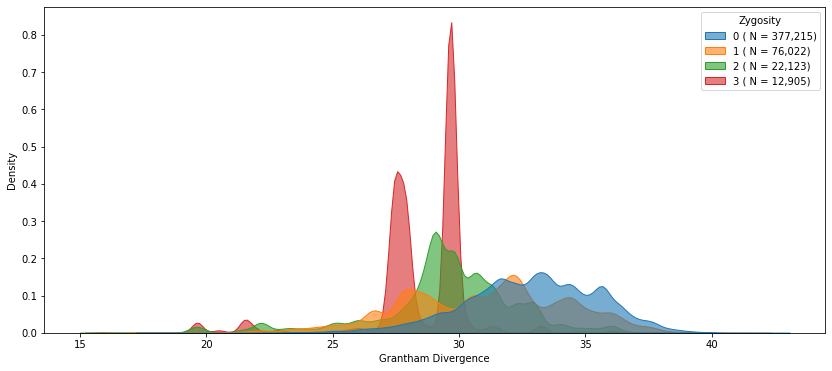

In [305]:
x, hue = "grantham_divergence", "zygosity"

fig, ax = plt.subplots(figsize=(14, 6))
sns_wrapper(sns.kdeplot, data=HLA_alleles, x=x, hue=hue, ax=ax, bw_method=.1, common_norm=False, shade=True)
add_plt_labels(ax, x=x, title="HGrantham Distance")

# fig.savefig(constants.COVER_PLOTS_GENERIC_FILE_PATH.format("HLA_grantham_distances.png"), facecolor="#fffffe")

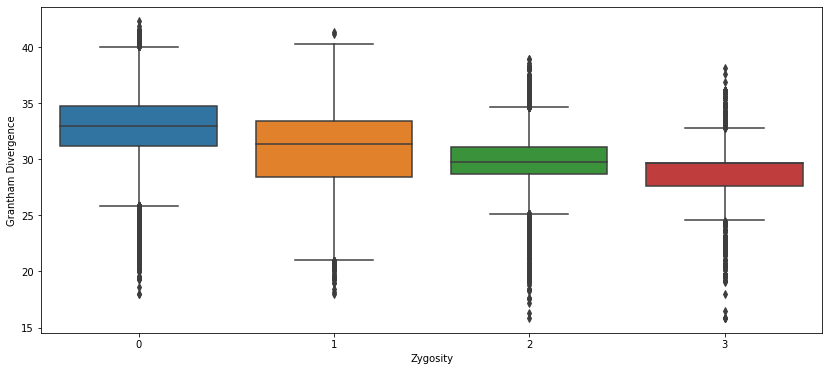

In [314]:
x, hue = "grantham_divergence", "zygosity"

fig, ax = plt.subplots(figsize=(14, 6))
sns.boxplot(data=HLA_alleles, x=hue, y=x, ax=ax)
add_plt_labels(ax, x=hue, y=x)